In [9]:
import glob
from utils import segnn_utils
import os
import numpy as np
import torch
import sys
from datasets.nbody.dataset_gravity import GravityDataset
import importlib
import json
from types import SimpleNamespace
%matplotlib inline

torch.manual_seed(42)

print(sys.executable)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#run = os.path.join("segnn_runs", "2024-03-18 18-38_gravityV2_segnn")
run = os.path.join("segnn_runs", "2024-03-20 11-01_gravityV2_segnn")

# training args
metadata_path = os.path.join(run, 'training_args.json')
if os.path.exists(metadata_path):
    with open(metadata_path, 'r') as json_file:
        args_dict = json.load(json_file)
    args = SimpleNamespace(**args_dict)
    args = SimpleNamespace(**args.args)

models = glob.glob(run + "/" + '*.pth')
if len(models) > 1:
    print("MORE MODELS FOUND IN THE DIR, LOADING THE FIRST:", models[0])

model = torch.load(models[0], map_location=device)
model.eval()

dataset = GravityDataset(partition='test', dataset_name=args.nbody_name,
                         max_samples=args.max_samples, neighbours=args.neighbours, target=args.target,
                         path=os.path.join(run, "gravity"))

t_delta = 2
loc, vel, force, mass = dataset.data
dims = loc.shape[-1]
boxSize = 5
particle_index = None

C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3_10\python.exe


### Getting prediction from batches, where a batch is all steps of a single simulation


In [2]:
from utils import segnn_utils

sim_indices = (i for i in range(3))
batch_simulations_predictions = segnn_utils.batch_prediction(model, dataset.data, args, device,
                                                             simulation_indices=sim_indices)

In [3]:
simulation_index = 0

batch_simulations_predicted_position_changes = batch_simulations_predictions[simulation_index, ..., :dims]
batch_simulations_predicted_positions = loc[simulation_index] + batch_simulations_predicted_position_changes

batch_targets = segnn_utils.get_targets(dataset.data, simulation_index=simulation_index, t_delta=t_delta)

dataset.simulation.interactive_trajectory_plot_all_particles_3d(batch_targets,
                                                                batch_simulations_predicted_positions,
                                                                particle_index,
                                                                boxSize=boxSize, dims=dims,
                                                                offline_plot=False)

Showing plot, you might need to bring the plot window in focus


---
# SELFFEED STEPWISE (len jedna simulacia, nie batch simulacii)
---


In [4]:
sim_indices = (i for i in range(30))
steps = 200

importlib.reload(segnn_utils)

self_feed_pos, self_feed_vel, self_feed_force = segnn_utils.self_feed_stepwise_prediction_parallel(
    model,
    dataset.data,
    dataset.simulation,
    args, device,
    simulation_indices=sim_indices,
    steps=steps)

### selffeed stepwise results

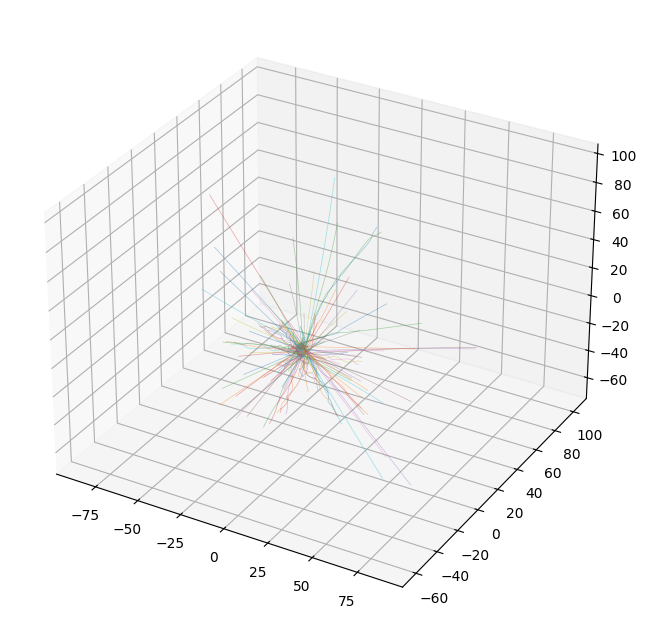

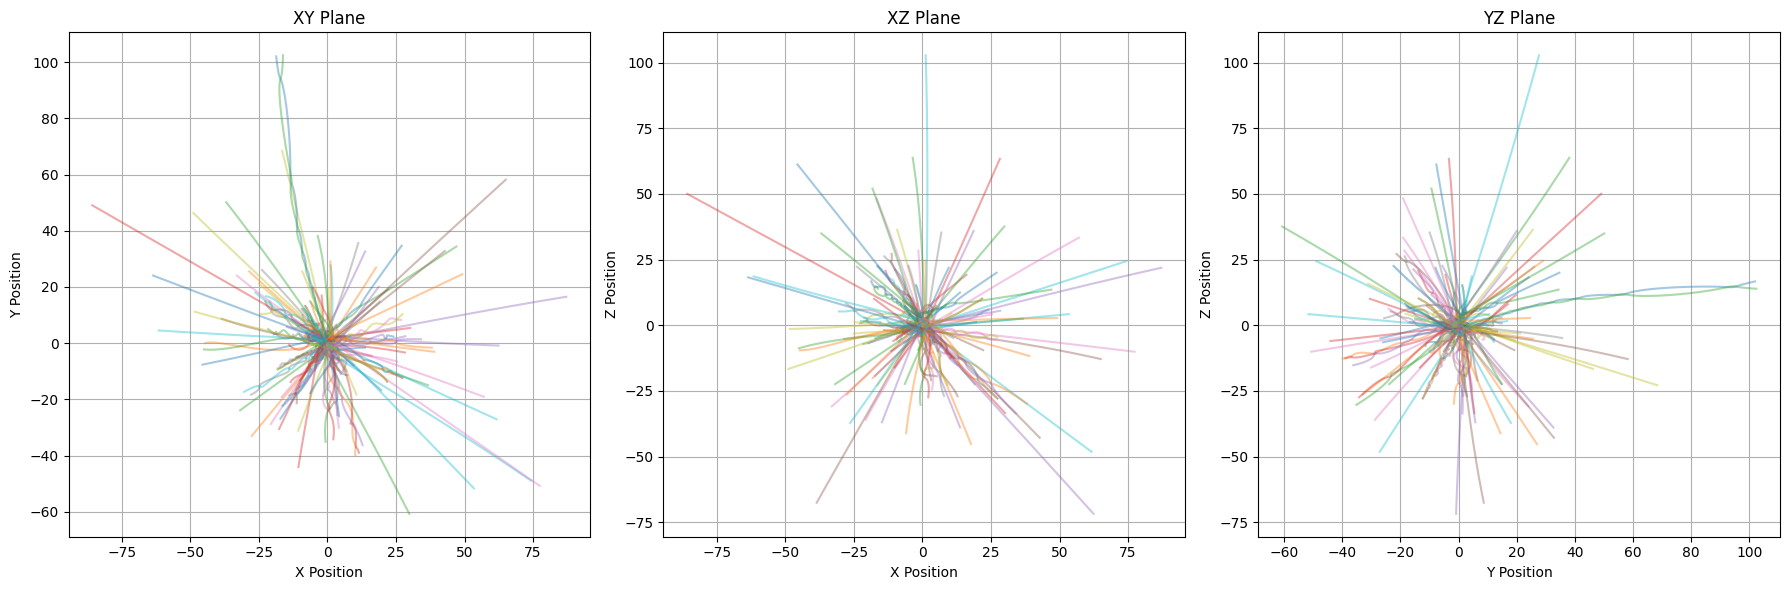

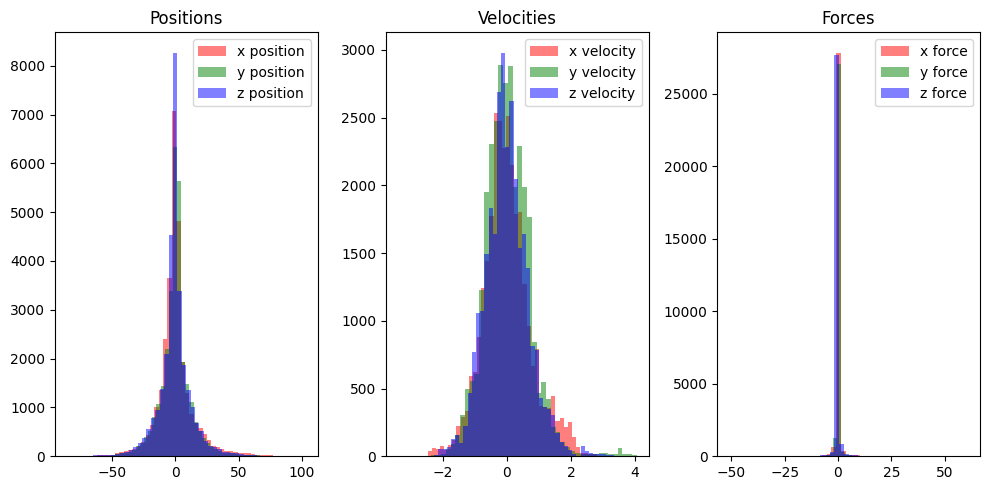

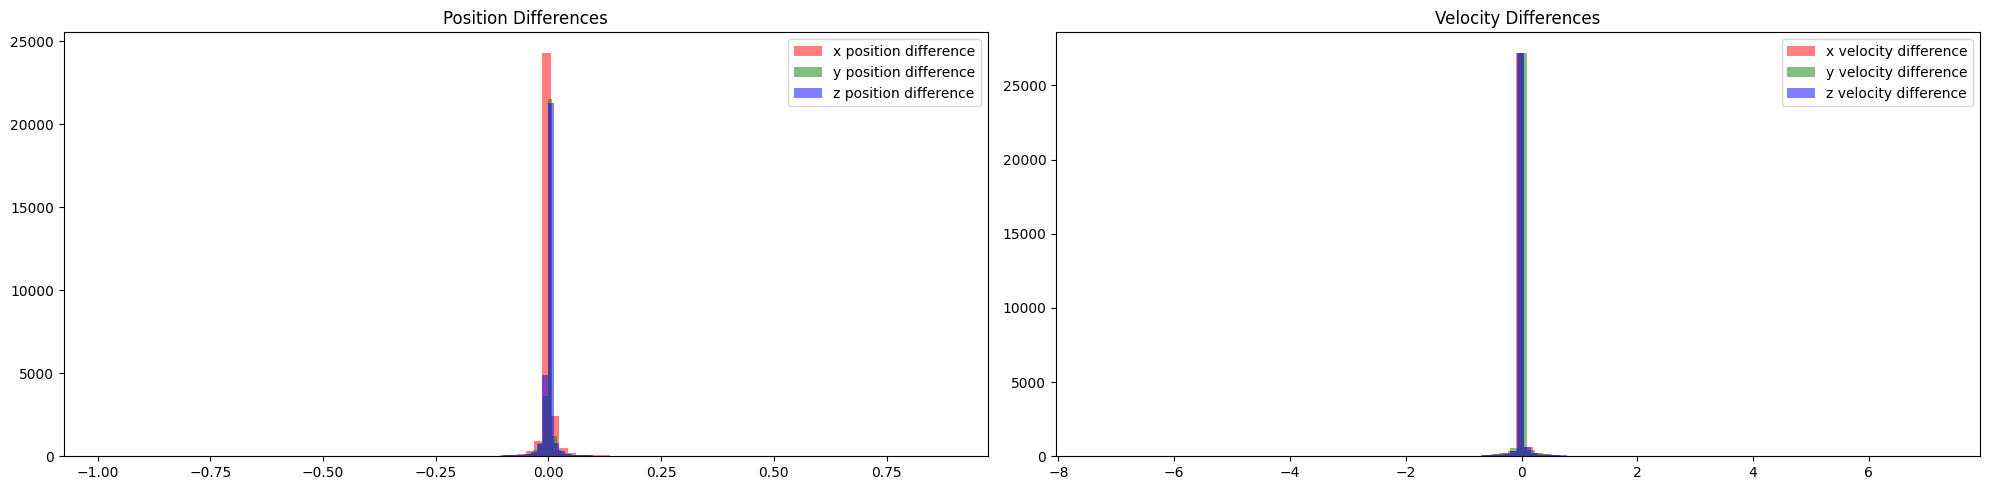

In [5]:
dataset.plot_trajectories_static(self_feed_pos, max_sims=100)
dataset.plot_trajectories_static_3D_to_2D(self_feed_pos, max_sims=100)
dataset.plot_histograms(self_feed_pos, self_feed_vel, self_feed_force, bins=50)
dataset.plot_differences(self_feed_pos, self_feed_vel, step=2, bins=100)

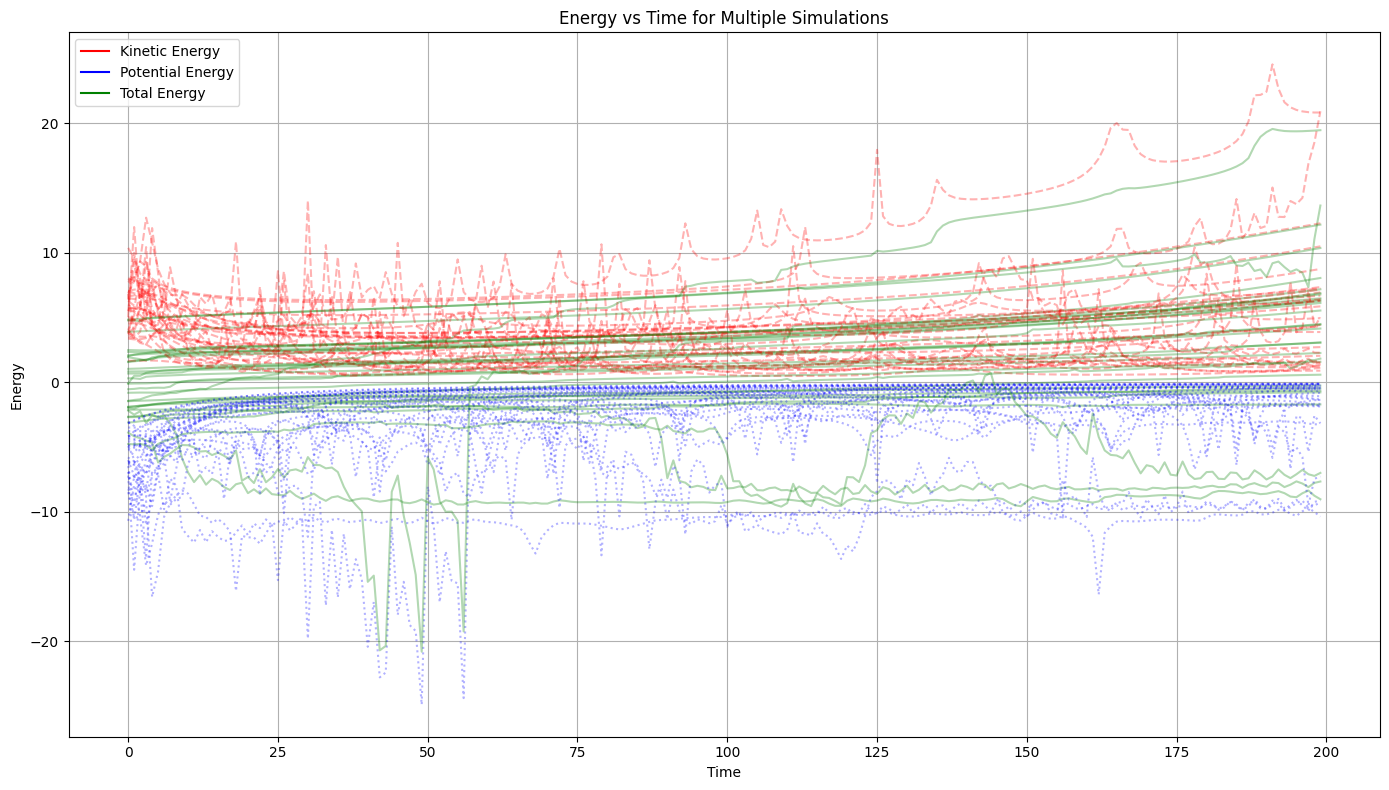

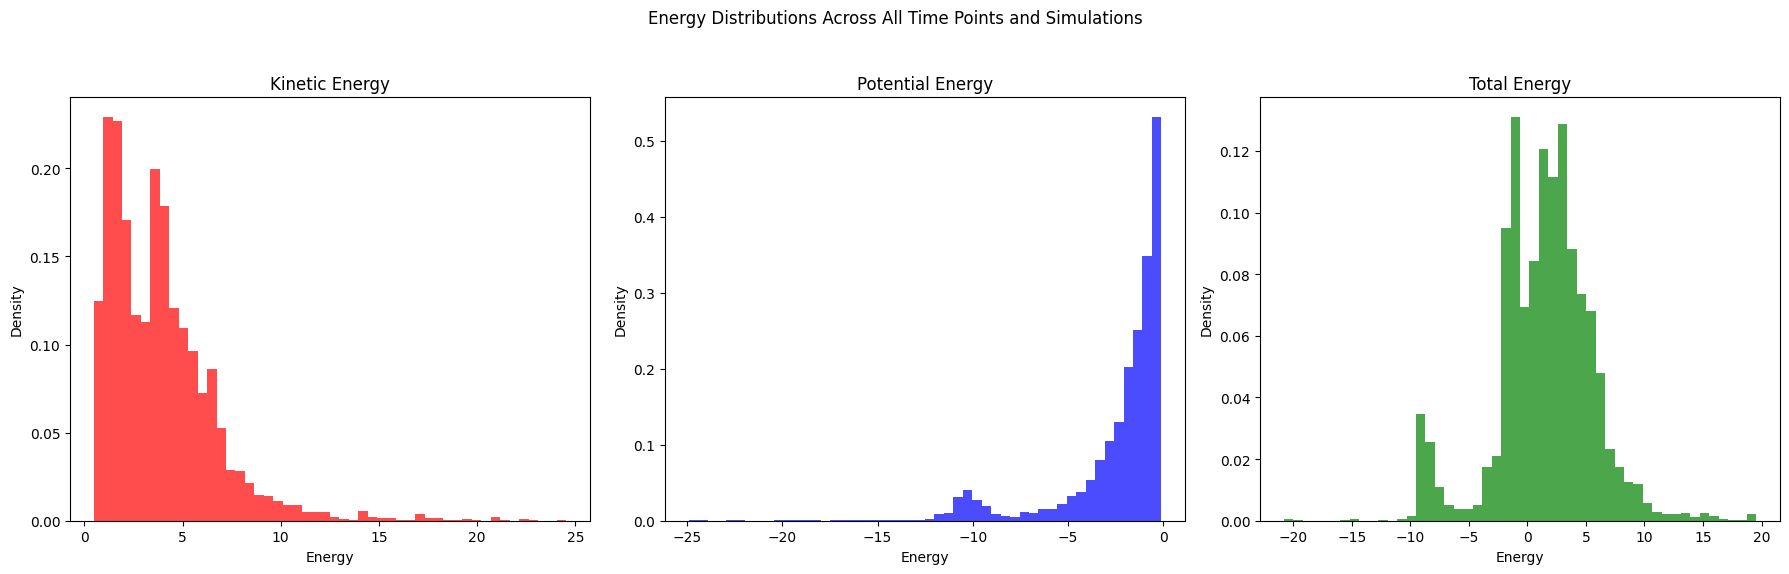

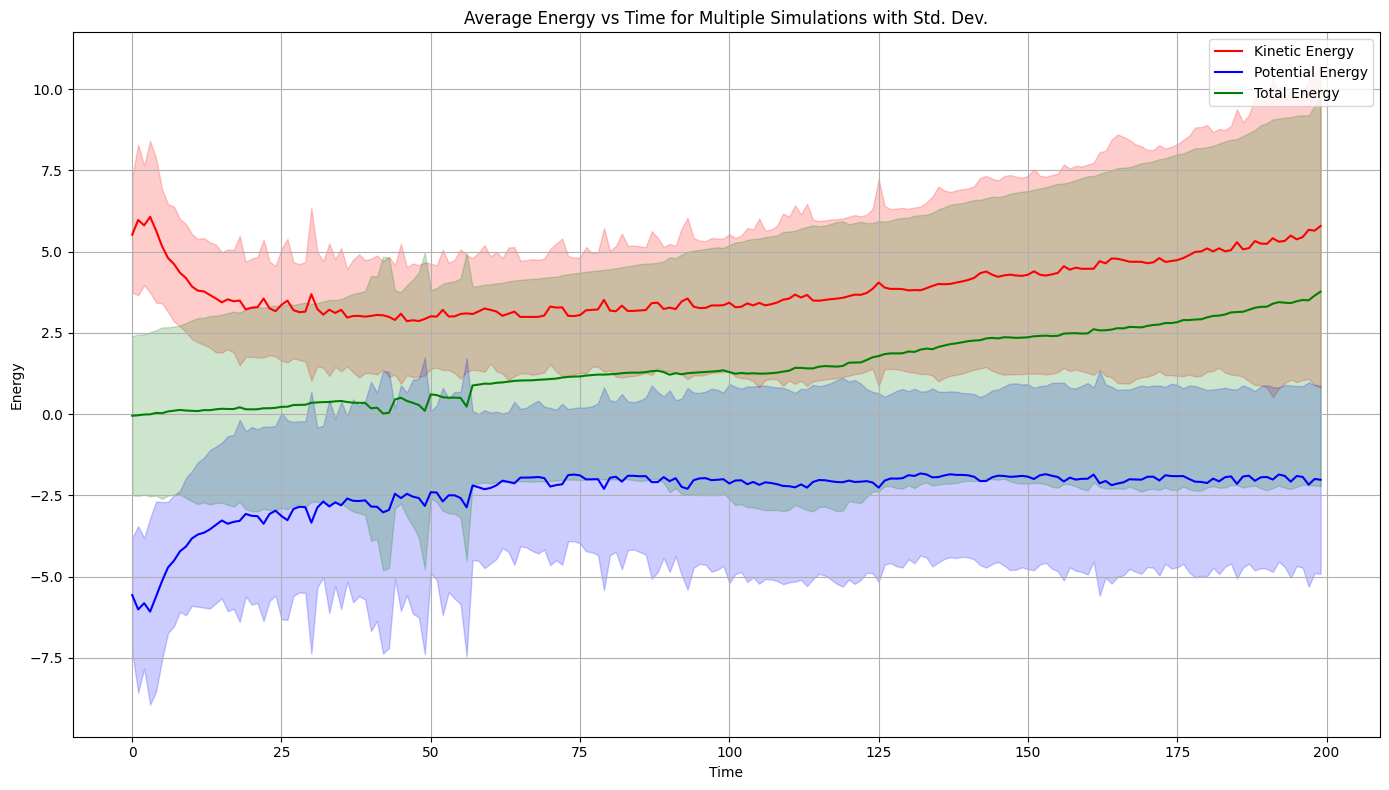

In [6]:
dataset.plot_energies_of_all_sims(self_feed_pos, self_feed_vel, self_feed_force, mass)
dataset.plot_energy_distributions_across_all_sims(self_feed_pos, self_feed_vel, self_feed_force, mass)
dataset.plot_energy_statistics(self_feed_pos, self_feed_vel, self_feed_force, mass)

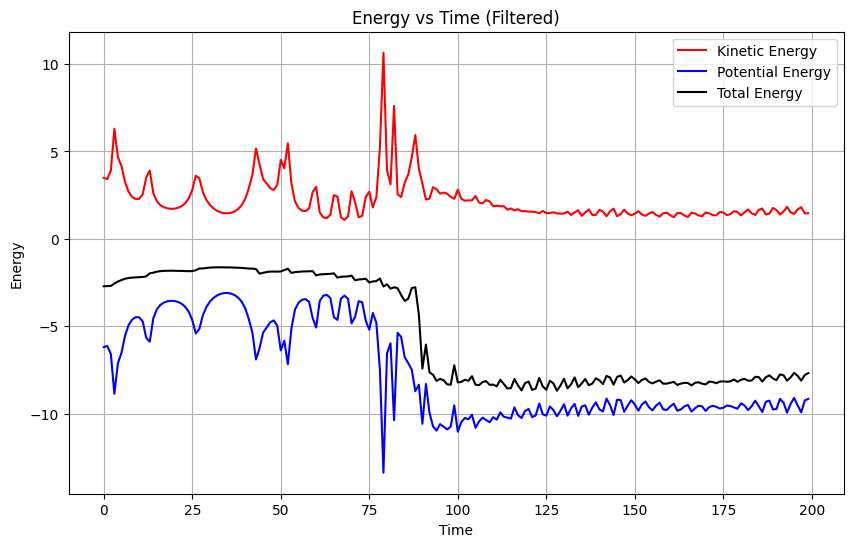

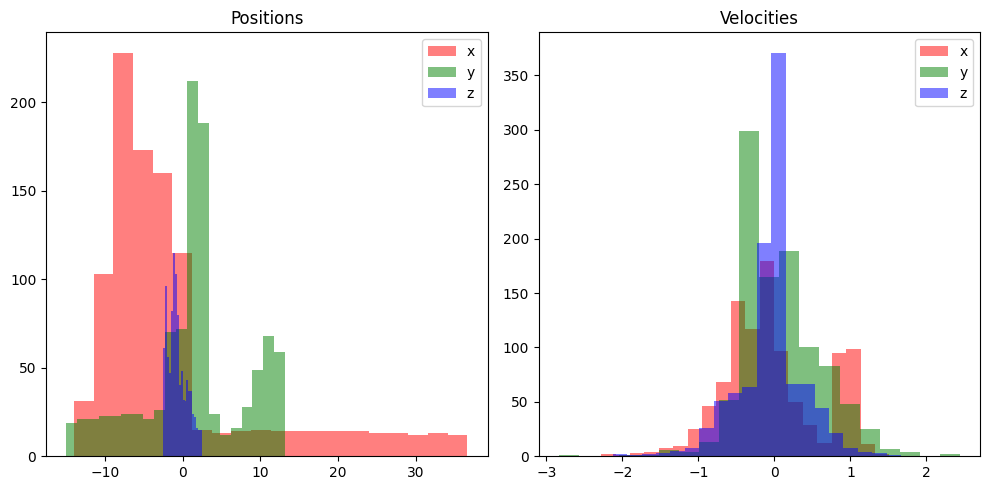

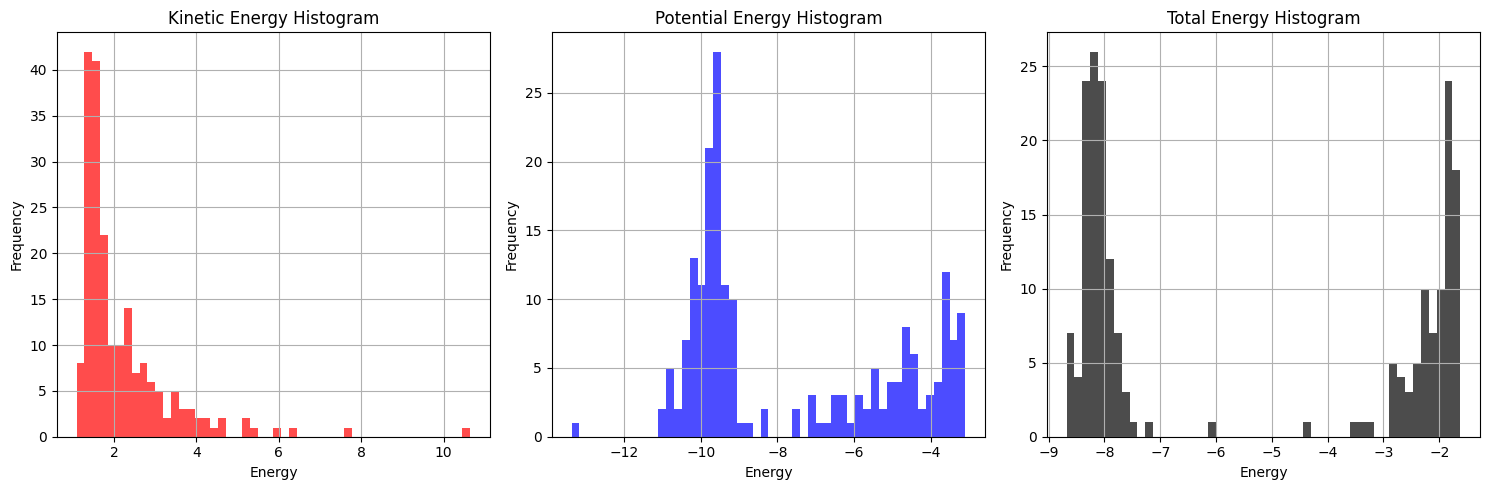

In [7]:
simulation_index = 2
dataset.simulation.plot_energies(self_feed_pos[simulation_index], self_feed_vel[simulation_index],
                                 mass[simulation_index])
dataset.simulation.plot_histograms(self_feed_pos[simulation_index], self_feed_vel[simulation_index])
dataset.simulation.plot_energy_distribution(self_feed_pos[simulation_index], self_feed_vel[simulation_index],
                                            mass[simulation_index], bins=50)

### Interactive plot of selffeed

In [8]:
particle_index = None
simulation_index = 2

self_feed_targets = segnn_utils.get_targets(dataset.data, simulation_index=simulation_index, t_delta=t_delta)

dataset.simulation.interactive_trajectory_plot_all_particles_3d(self_feed_targets,
                                                                self_feed_pos[simulation_index],
                                                                particle_index,
                                                                boxSize=10, dims=dims,
                                                                offline_plot=False, alpha=0.2)

Showing plot, you might need to bring the plot window in focus


---
# SELFFEED BATCH
---

In [10]:
importlib.reload(segnn_utils)
n_sims = 30
steps = 300

self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force = segnn_utils.self_feed_batch_prediction(model,
                                                                                                         dataset.data,
                                                                                                         dataset.simulation,
                                                                                                         args, device,
                                                                                                         n_sims=n_sims,
                                                                                                         steps=steps)

In [11]:
particle_index = None
simulation_index = 2

self_feed_batch_targets = segnn_utils.get_targets(dataset.data, simulation_index=simulation_index,
                                                  t_delta=t_delta)
dataset.simulation.interactive_trajectory_plot_all_particles_3d(self_feed_batch_targets,
                                                                self_feed_batch_pos[simulation_index],
                                                                particle_index,
                                                                boxSize=10, dims=dims,
                                                                offline_plot=False, alpha=0.2)

Showing plot, you might need to bring the plot window in focus


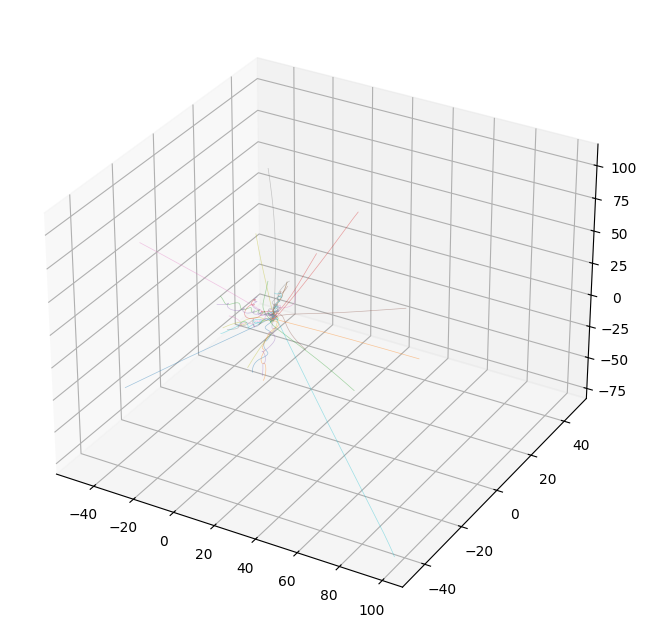

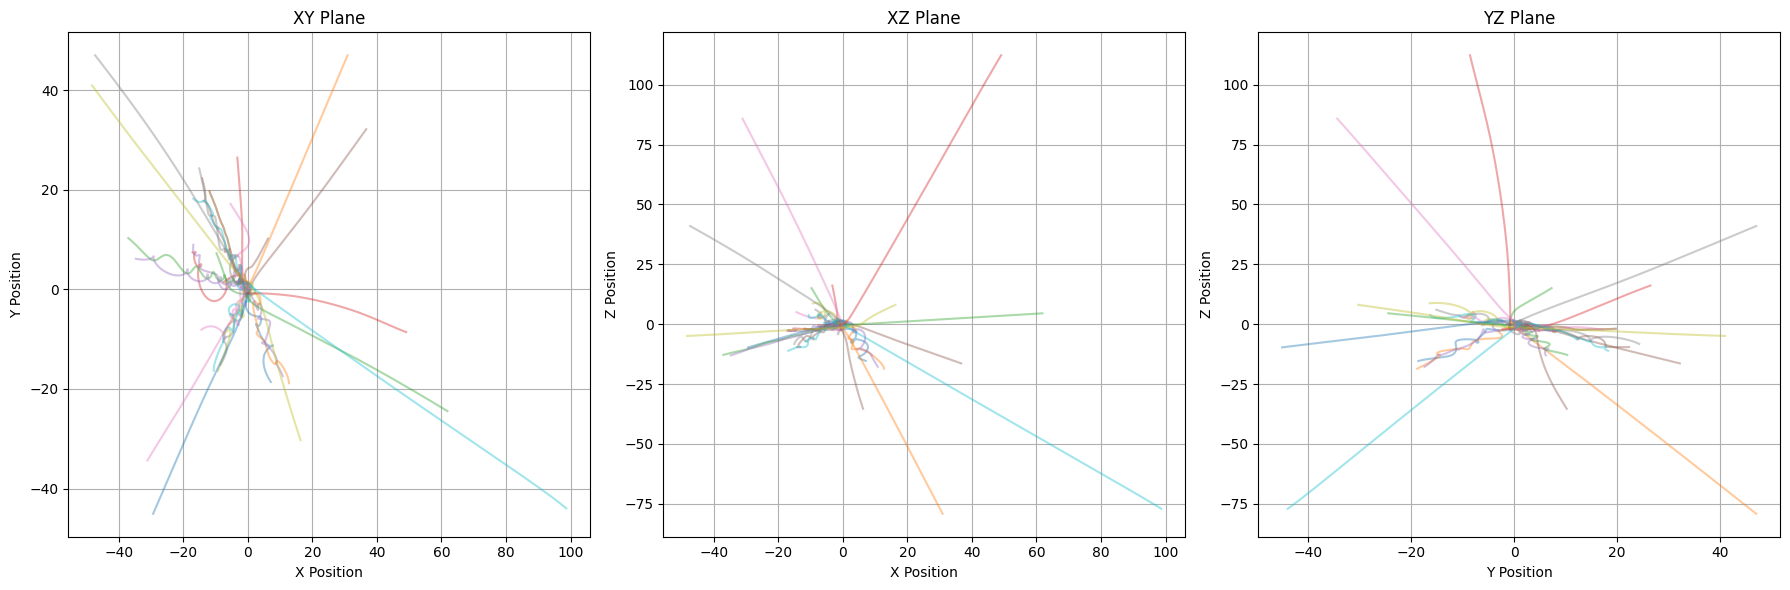

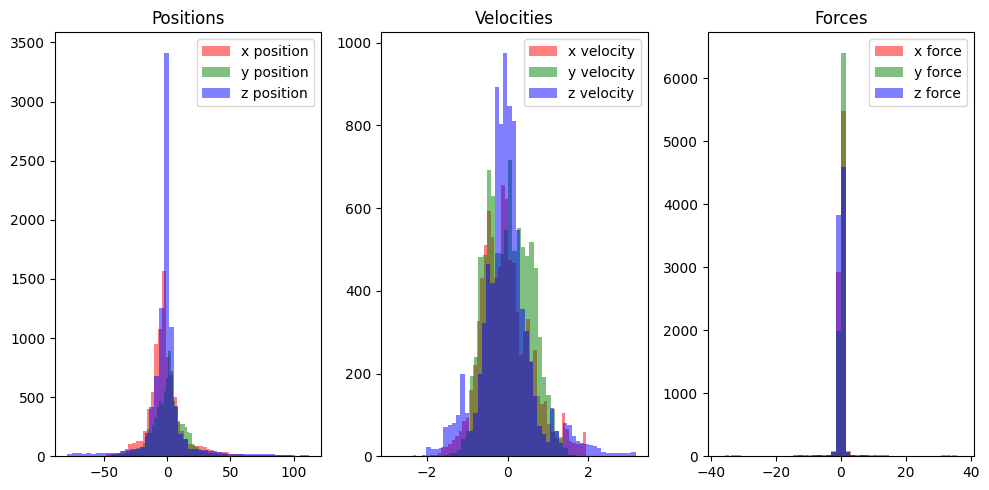

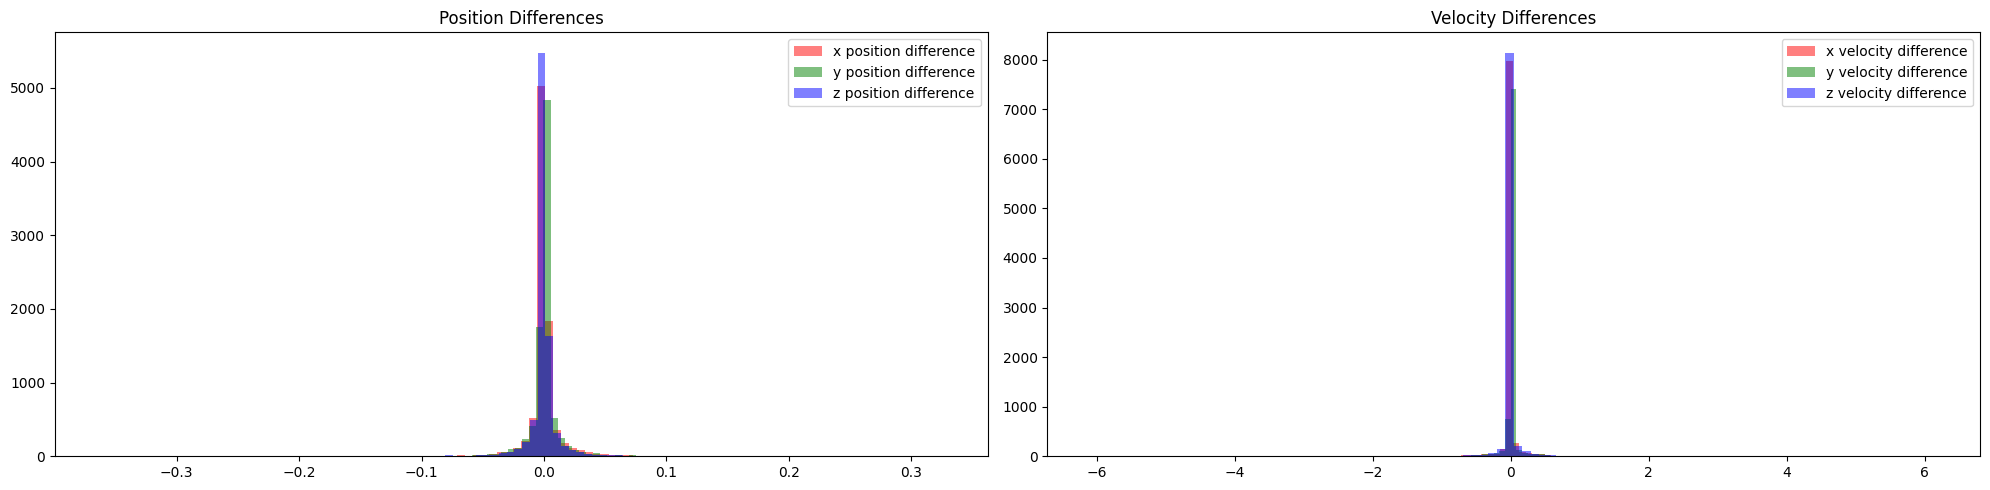

In [12]:
dataset.plot_trajectories_static(self_feed_batch_pos, max_sims=100)
dataset.plot_trajectories_static_3D_to_2D(self_feed_batch_pos, max_sims=100)
dataset.plot_histograms(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, bins=50)
dataset.plot_differences(self_feed_batch_pos, self_feed_batch_vel, step=2, bins=100)

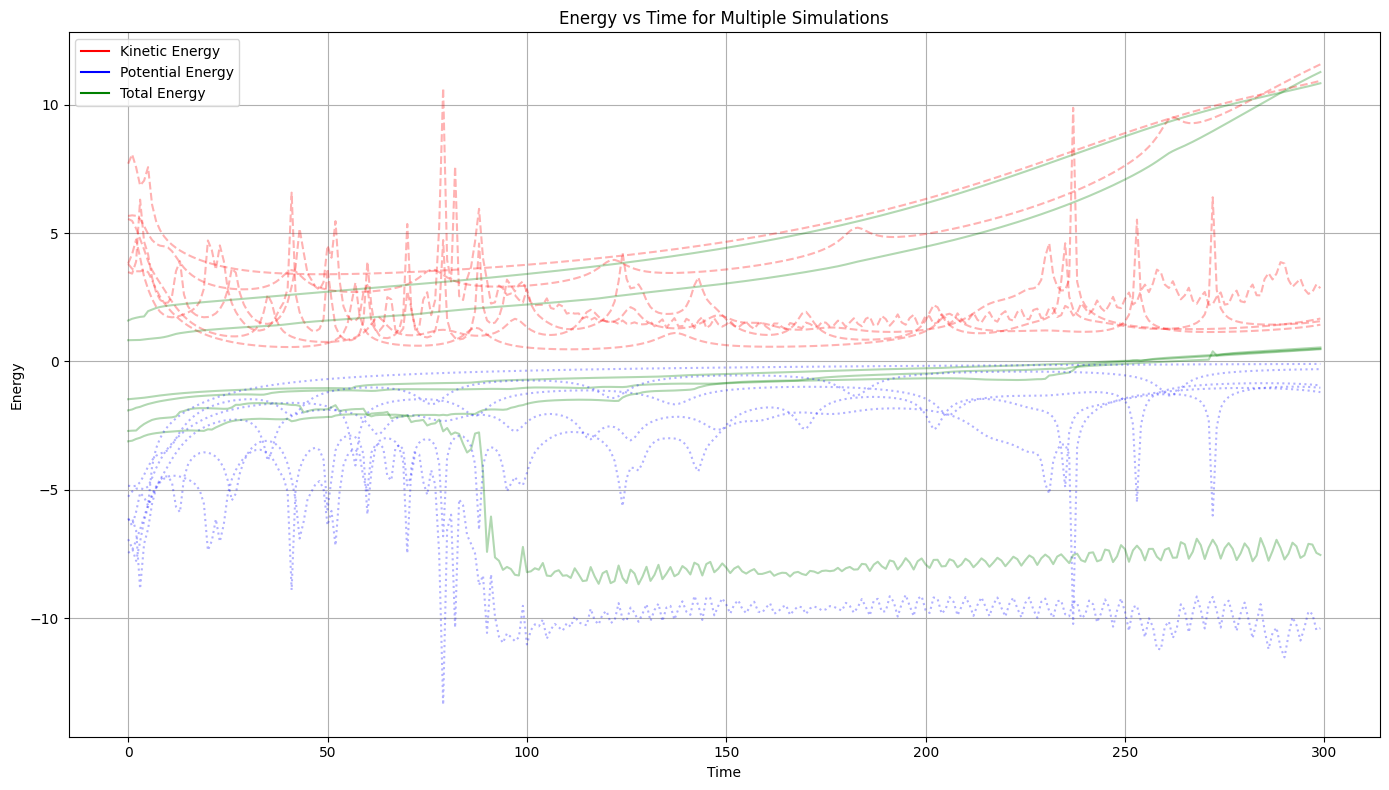

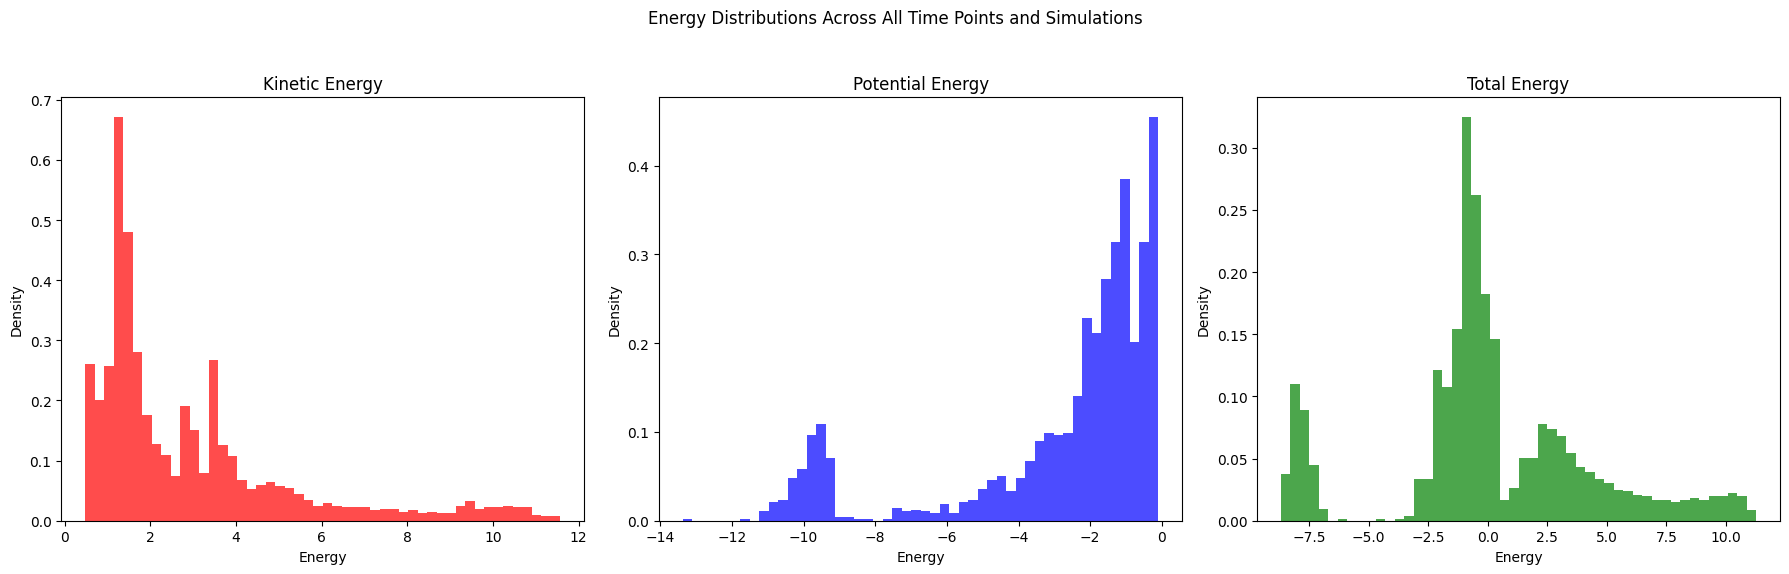

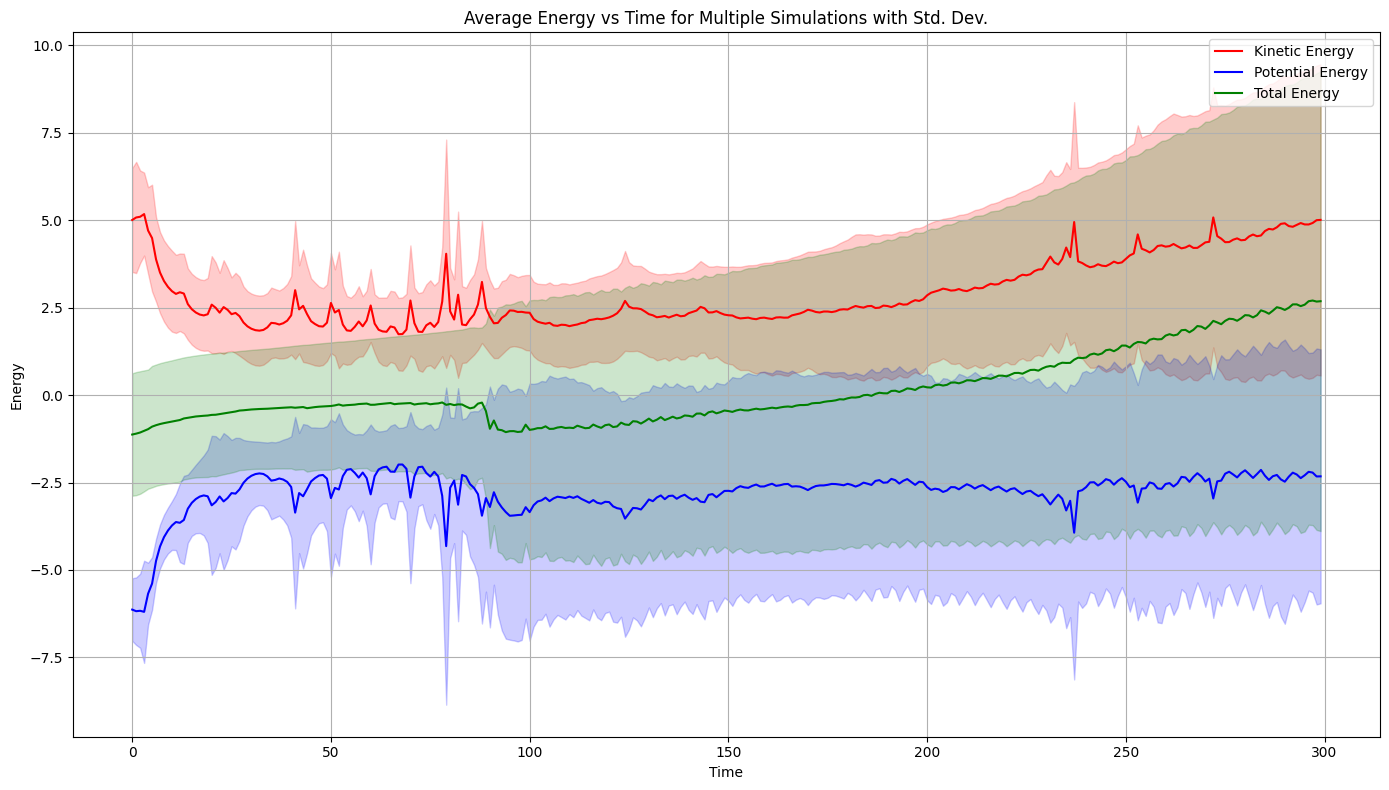

In [13]:
dataset.plot_energies_of_all_sims(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, mass)
dataset.plot_energy_distributions_across_all_sims(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, mass)
dataset.plot_energy_statistics(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, mass)

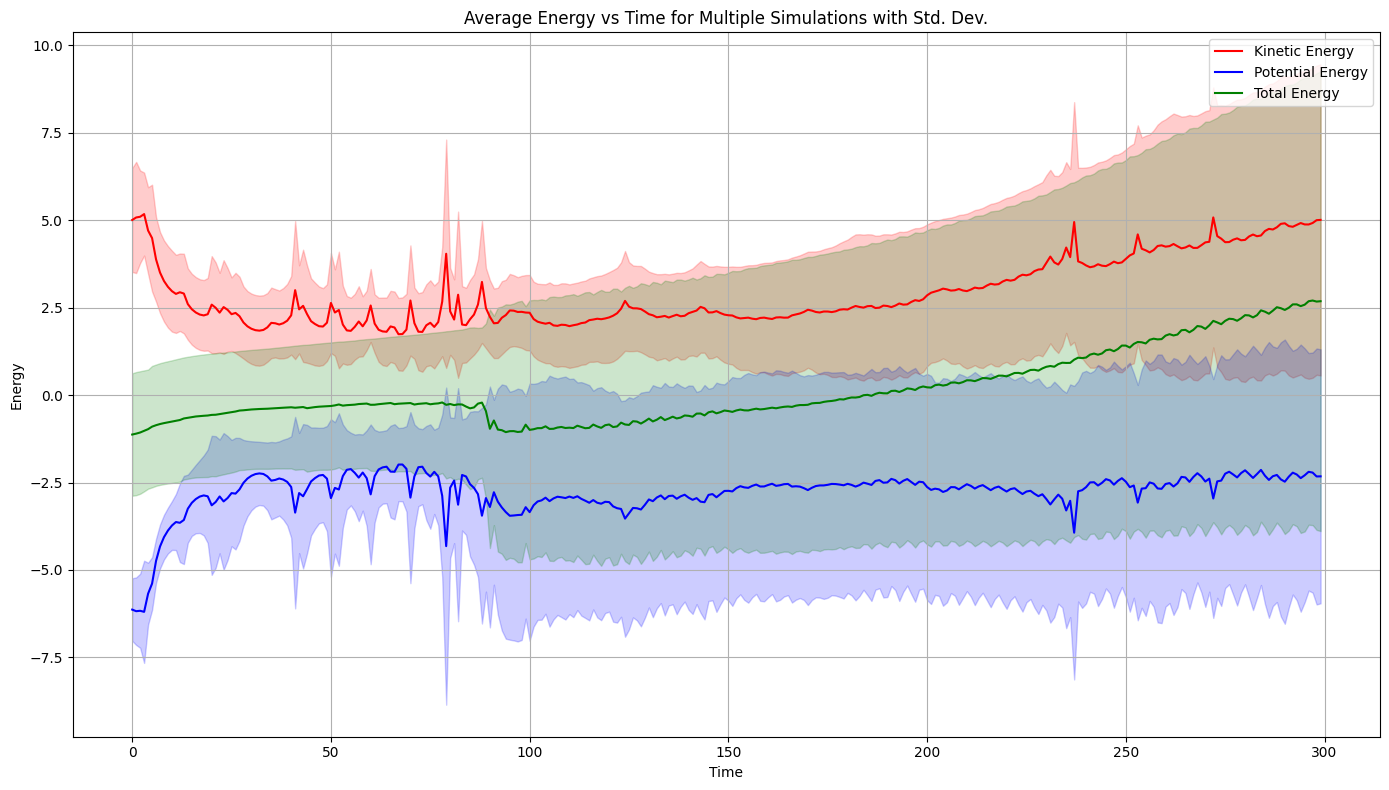

In [23]:
import utils.loggers as loggers
import wandb
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(run)

log_manager = loggers.LoggingManager()
log_manager.add_logger(loggers.TensorBoardLogger(writer, None))

# if loggers.WandBLogger.get_api_key() is not None:
#     existing_run_id = '0drs6ko5'
#     wandb.init(project=args.experiment_name, id=existing_run_id, resume="must")
# 
#     wandb_logger = loggers.WandBLogger(run=wandb.run)
# 
#     # Add the wandb_logger to your log_manager
#     log_manager.add_logger(wandb_logger)

import importlib
import datasets.nbody.dataset_gravity as dataset_gravity


importlib.reload(dataset_gravity)

dataset = dataset_gravity.GravityDataset(partition='test', dataset_name=args.nbody_name,
                         max_samples=args.max_samples, neighbours=args.neighbours, target=args.target,
                         path=os.path.join(run, "gravity"))

dataset.plot_energy_statistics(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, mass, log_manager=log_manager)

# Compare stepwise vs batch

In [18]:
import importlib

importlib.reload(segnn_utils)
a, b = segnn_utils.compare_batch_vs_step(model, dataset, device, args, num_simulations=5)

Difference: 2.6819425428492178e-17


In [19]:
np.abs((self_feed_pos - self_feed_batch_pos).mean())

0.11658573562583589